In [2]:
""" Inflation Prediction Study
Author: Camilla Nore
Date:   2015-08-30
"""
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 5.0)

# NB: As this is iPython, the module will be cached. If you change 
#     the module, you have to restart the iPython kernel.
from inflastudy import InflaData  # Custom module for this study.
from inflastudy import decode_column_name # Decode column name
from inflastudy import NaivePredictions
from inflastudy import error_calculation

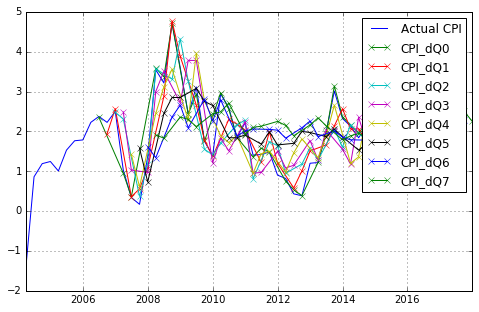

In [3]:
""" Load the data file"""

data = InflaData.InflaData(filename='data/kongepanel_upd_oppdatert_mars.csv')
data.remap_to_relative_time(prediction_horizon=16)
data.plot_relative_time_cpi_data()
#print data.raw_data.CPI       # Uncomment this line to see raw CPI data.
#print data.raw_data.columns   # Uncomment this line to see column names.
#print(data.cpi_pred_relative)

In [5]:
# Calculate naive values and error
actual_cpi = data.raw_data['CPI']
naive = NaivePredictions.NaivePredictions(actual_cpi)
naive_error = error_calculation.PredictionError(naive.data)

NameError: name 'data' is not defined

In [6]:
# Calculate cpi error
cpi_error = error_calculation.PredictionError(data.cpi_pred_relative)

NameError: name 'data' is not defined

In [7]:
# Plot and compare with naive.
cpi_error.plot_selected()
naive_error.plot_selected()

NameError: name 'cpi_error' is not defined

In [8]:
# Plot and compare rms with naive
cpi_error.plot_rms()
naive_error.plot_rms()

NameError: name 'cpi_error' is not defined

In [9]:
#Plot and compare the mean with naive
cpi_error.plot_mean()
naive_error.plot_mean()

NameError: name 'cpi_error' is not defined

In [10]:
# Export the data to csv.
#data.cpi_pred_error.to_excel('pred_error.xlsx')
data.cpi_pred_relative.to_excel('cpi_pred_relative.xlsx')

NameError: name 'data' is not defined

NameError: name 'data' is not defined

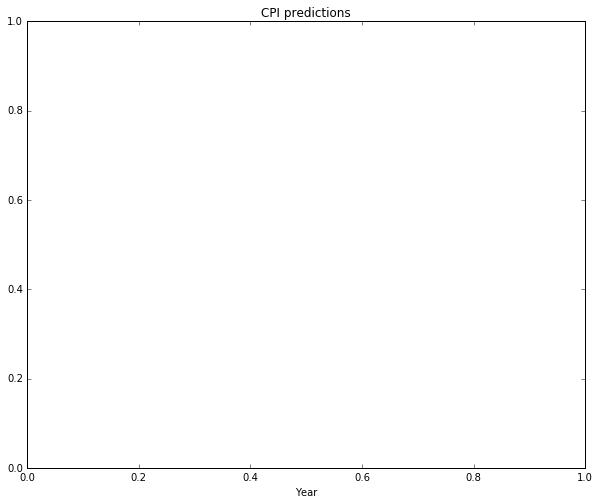

In [11]:
""" Plot all CPI predictions and the actual CPI. """

plt.figure('CPI predictions', figsize=(10,8))  # Larger plot.
plt.title('CPI predictions')
plt.xlabel('Year')
# Plot the actual CPI as a solid line.
plt.plot(data.raw_data.index,
         data.raw_data['CPI'],
         label ='CPI')

for col_name in data.cpi_predictions:
    plt.plot(data.cpi_predictions.index,
             data.cpi_predictions[col_name],
             '--',
             label = 'col_name')

In [ ]:
""" Plot all CPI-jae predictions and the actual CPI-jae. """

plt.figure('CPI jae predictions', figsize=(10,8))  # Larger plot.
plt.title('CPI jae predictions')
plt.xlabel('Year')

# Plot the actual CPI as a solid line.
plt.plot(data.raw_data.index,
         data.raw_data['CPI-jae'],
         label ='CPI jae')

for col_name in data.cpi_jae_predictions:
    plt.plot(data.cpi_jae_predictions.index,
             data.cpi_jae_predictions[col_name],
             '--',
             label = 'col_name')
